In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table  
import emcee 
import corner
import sklearn.mixture as sk

In [2]:
data= Table.read('Abell2142.csv')
print(data)

G = 6.67259*10**-11
rad = 1/3*np.pi/180
m_sun = 1.98855*10**30 #kg
c = 3*10**8
H0 = 7*10**4

     ra          dec      dered_u  ... lgm_tot_p50 lgm_tot_p16 lgm_tot_p84
------------ ----------- --------- ... ----------- ----------- -----------
239.58332907 27.23341292 17.767288 ...   11.695192   11.611497   11.773891
 239.5780388 27.23910305  19.17033 ...   10.920323   10.824115    11.01576
 239.5693859 27.23673589 20.153168 ...   10.877969   10.798607   10.954689
239.60272281  27.2295196 19.287027 ...   11.136953   11.047954   11.220408
239.60532702 27.23314459 21.533886 ...   10.561258   10.466826   10.654852
239.60595884 27.24582845 20.146353 ...   10.818638   10.737638   10.902952
239.53101584 27.24548441 20.098499 ...   10.837231   10.748996   10.933403
239.55254502 27.20793831 20.254349 ...   10.543205   10.450591   10.631782
239.59648413 27.20714653 19.899858 ...   10.780937   10.691547   10.869298
  239.555405  27.2481222 17.927557 ...   11.705176   11.616172   11.785342
         ...         ...       ... ...         ...         ...         ...
239.69569611 27.26469232 

0.10162295833333335
0.0905155


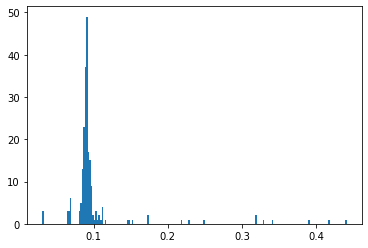

In [3]:
z = np.array(data['z'])
plt.hist(z, bins=200);
print(np.mean(z))
print(np.median(z))
data_sel = data[(z>0.05)&(z<0.15)]
z_sel = np.array(data_sel['z'])
a = np.zeros(len(z_sel))

In [4]:
def log_likelihood(p, z):
    z0, sigmaz0, k = p    #parametri della distribuzione
    
    #log_p = np.log(k+np.exp(-(z0-z)**2 / (2*(sigmaz0**2)))/(2*np.pi*(sigmaz0**2))**0.5)-np.log(1+k*(0.1))
    log_p = np.log((1-k)/0.1+k*np.exp(-(z0-z)**2 / (2*(sigmaz0**2)))/(2*np.pi*(sigmaz0**2))**0.5)         #mistura gaussiana + uniforme
    return np.sum(log_p)
    
def log_prior(p):
    z0, sigmaz0, k = p
    if (z0<0.05 or z0>0.15) or (sigmaz0<0) or (k<0 or k>1) :   #limiti dei parametri
        return -np.inf
    else:
        return 0     #distribuzione a priori uniforme non normalizzata
    
def log_posterior(p, z, a):
    lp = log_prior(p)
    if np.isfinite(lp):
        return lp + log_likelihood(p, z)
    else:
        return lp

In [5]:
ndim = 3
nwalkers = 20

z0 = np.random.normal(0.1,0.001,size=nwalkers)    
sigmaz0 = np.random.normal(0.01,0.001,size=nwalkers)
k = np.random.normal(0.5,0.001,size=nwalkers) 

start = np.zeros((nwalkers,ndim))
for i in range(nwalkers):
    start[i] = (z0[i],sigmaz0[i],k[i])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_sel, a))  
sampler.run_mcmc(start, 20000, progress=True);
sampler.reset()
sampler.run_mcmc(initial_state=None,nsteps=30000, progress=True);

100%|██████████| 30000/30000 [00:30<00:00, 998.11it/s] 


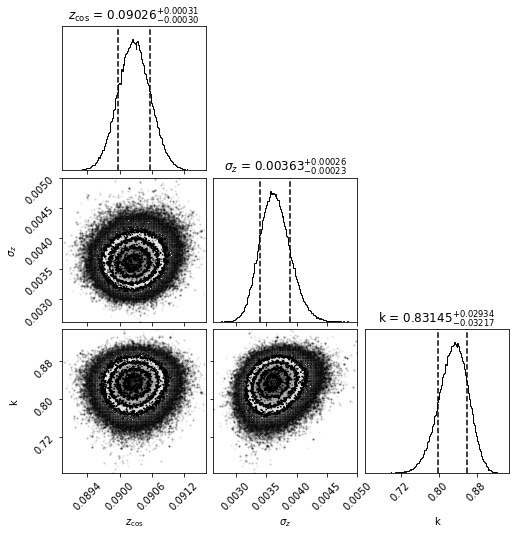

In [6]:
corner.corner(sampler.flatchain[:],bins=200, quantiles=[0.16, 0.84],
              show_titles=True,title_fmt='.5f', labels=['$z_\mathrm{cos}$', '$\sigma_z$', 'k']);
plt.savefig('CornerAbell.pdf')

[0.08967487] [0.0908707]
[0.0031898] [0.00416979]
Redshift cluster
[0.09026281]
[0.00030139]
Dispersione velocità (km/s)
[999.28213884]
[-64.36654537] [70.96114077]
[6.96313121e+22]
Massa totale (M_sun) modello SIS
[1.04804485e+15]
[-1.3066663e+14] [1.54132766e+14]
Massa totale (M_sun) viriale
[2.62011213e+15]
[-3.26666574e+14] [3.85331915e+14]
Frazione di massa stellare
[0.00447348]
[-0.00066364] [0.00056736]


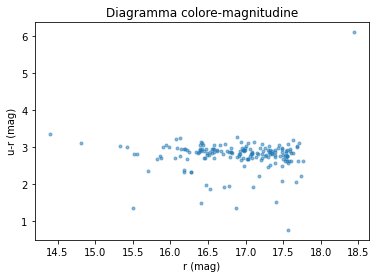

In [10]:
z_cluster = corner.quantile(sampler.flatchain[:,0], 0.5)
err_z = 0.5*(corner.quantile(sampler.flatchain[:,0], 0.84)-corner.quantile(sampler.flatchain[:,0], 0.16))
sigma_z = corner.quantile(sampler.flatchain[:,1], 0.5)
err_sigma_z = 0.5*(corner.quantile(sampler.flatchain[:,1], 0.84)-corner.quantile(sampler.flatchain[:,1], 0.16))

print(corner.quantile(sampler.flatchain[:,0], 0.025),corner.quantile(sampler.flatchain[:,0], 0.975))
print(corner.quantile(sampler.flatchain[:,1], 0.025),corner.quantile(sampler.flatchain[:,1], 0.975))

sigma_vels_ab = c*sampler.flatchain[:,1]/(1+sampler.flatchain[:,0])
sigma_v_ab = corner.quantile(sigma_vels_ab, 0.5)
err_sigma_vels_ab_sx = corner.quantile(sigma_vels_ab, 0.16)-corner.quantile(sigma_vels_ab, 0.5)
err_sigma_vels_ab_dx = corner.quantile(sigma_vels_ab, 0.84)-corner.quantile(sigma_vels_ab, 0.5)

print('Redshift cluster')
print(z_cluster)
print(err_z)
print('Dispersione velocità (km/s)')
print(sigma_v_ab/1000)
print(err_sigma_vels_ab_sx/1000, err_sigma_vels_ab_dx/1000)

cluster = data[(z>z_cluster-3*sigma_z)&(z<z_cluster+3*sigma_z)]
#print(len(cluster))

u = np.array(cluster['dered_u'])
r = np.array(cluster['dered_r'])
plt.plot(r,u-r, '.', alpha=0.5);
plt.xlabel('r (mag)')
plt.ylabel('u-r (mag)')
plt.title('Diagramma colore-magnitudine')
plt.savefig('grafColoreMag.pdf')

R = rad*(c/H0)*z_cluster*10**6*(150*10**9*3600*180/np.pi)     #apertura 20'
err_R = R*err_z/z_cluster
print(R)
Ms_tot = 2*(sigma_vels_ab**2)*R/(G*m_sun)     #massa 2D con SIS
M_tot = corner.quantile(Ms_tot, 0.5)
err_M_tot_sx = corner.quantile(Ms_tot, 0.16)-corner.quantile(Ms_tot, 0.5)
err_M_tot_dx = corner.quantile(Ms_tot, 0.84)-corner.quantile(Ms_tot, 0.5)
print('Massa totale (M_sun) modello SIS')
print(M_tot)
print(err_M_tot_sx,err_M_tot_dx)

Ms_vir = 5*(sigma_vels_ab**2)*R/(G*m_sun)     #massa viriale
M_vir = corner.quantile(Ms_vir, 0.5)
err_M_vir_sx = corner.quantile(Ms_vir, 0.16)-corner.quantile(Ms_vir, 0.5)
err_M_vir_dx = corner.quantile(Ms_vir, 0.84)-corner.quantile(Ms_vir, 0.5)
print('Massa totale (M_sun) viriale')
print(M_vir)
print(err_M_vir_sx,err_M_vir_dx)

mass = np.array(10**cluster['lgm_tot_p50'])
err_mass_sx = np.array(10**cluster['lgm_tot_p16']-10**cluster['lgm_tot_p50'])
err_mass_dx = np.array(10**cluster['lgm_tot_p84']-10**cluster['lgm_tot_p50'])
M_star = np.sum(mass)
err_M_star_sx = np.sqrt(np.sum(err_mass_sx**2))
err_M_star_dx = np.sqrt(np.sum(err_mass_dx**2))
f_star = M_star/M_vir
err_f_sx = -f_star*np.sqrt((err_M_star_sx/M_star)**2+(err_M_vir_dx/M_vir)**2)
err_f_dx = f_star*np.sqrt((err_M_star_dx/M_star)**2+(err_M_vir_sx/M_vir)**2)
print('Frazione di massa stellare')
print(f_star)
print(err_f_sx,err_f_dx)

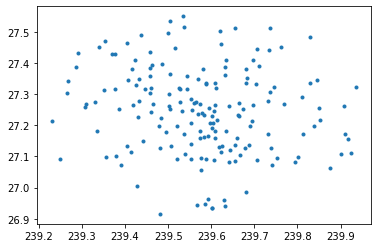

In [11]:
ra = np.array(cluster['ra'])
dec = np.array(cluster['dec'])
plt.plot(ra,dec,'.');

In [13]:
D = c/H0 * z_cluster   #Mpc
print(D)

[386.85913208]


In [18]:
data2= Table.read('dati3.csv')
#print(data2)
G = 6.67259*10**-11
rad = 1/3*np.pi/180
m_sun = 1.98855*10**30 #kg
c = 3*10**8
H0 = 7*10**4

selected = data2[(data2['Flag']>=2)]
print(selected)

col0   ID      RA       DEC     ...  Mag           Catalog           Origin
---- ----- --------- ---------- ... ----- -------------------------- ------
  -- 14100 63.879843 -24.254507 ... 19.32    M0416_LRb_p4_M2_Q4_71_1      1
  -- 15004 64.066112 -24.261057 ... 19.92    M0416_LRb_p3_M2_Q4_69_1      1
  -- 15099 64.059571 -24.261808 ... 20.93   M0416_LRb_p3_M3_Q4_109_1      1
  -- 15746 64.226374 -24.262606 ... 21.94 M0416_LRb_p3_M2_2_Q1_130_1      1
  -- 15892 63.838858   -24.2529 ...  19.6    M0416_LRb_p4_M2_Q4_69_1      1
  -- 16096 64.041928 -24.262141 ... 21.95   M0416_LRb_p3_M1_Q4_141_1      1
  -- 16173 63.930875 -24.254946 ... 19.56    M0416_LRb_p4_M2_Q4_72_1      1
  -- 16215  64.05857 -24.263075 ... 22.61 M0416_LRb_p3_M2_2_Q4_103_1      1
  -- 16216 64.135563 -24.263133 ... 23.06    M0416_LRb_p3_M1_Q1_65_1      1
  -- 16244 64.079154 -24.262658 ... 22.37    M0416_LRb_p3_M2_Q4_70_1      1
 ...   ...       ...        ... ...   ...                        ...    ...
  --  -233 6

0.5652987157161515
0.40875


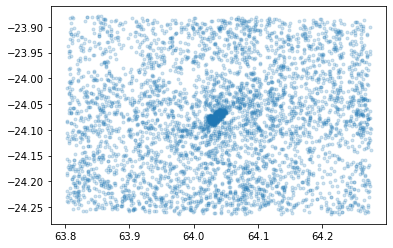

In [20]:
z = np.array(selected['Z'])
#plt.hist(z, bins=100);
print(np.mean(z))
print(np.median(z))
plt.plot(selected['RA'], selected['DEC'], '.', alpha=0.2);

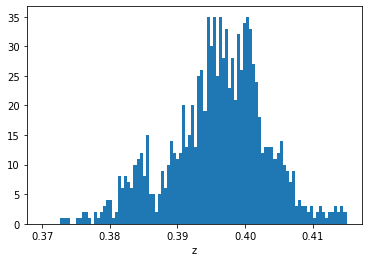

In [19]:
data_sel = selected[(z>0.37)&(z<0.415)]
z_sel = np.array(data_sel['Z'])
plt.hist(z_sel, bins=100, range=[0.37,0.415]);
plt.xlabel('z')
a = np.zeros(len(z_sel))
plt.savefig('histUnknown.pdf')

In [11]:
def log_likelihood(p, z):
    z0, sigmaz0, k0, z1, sigmaz1, k1 = p    #parametri della distribuzione
    
    log_p = np.log((1-k0-k1)/0.045+k0*np.exp(-(z0-z)**2 / (2*(sigmaz0**2)))/(2*np.pi*(sigmaz0**2))**0.5+k1*np.exp(-(z1-z)**2 / (2*(sigmaz1**2)))/(2*np.pi*(sigmaz1**2))**0.5)         #mistura 2 gaussiane + uniforme
    return np.sum(log_p)
    
def log_prior(p):
    z0, sigmaz0, k0, z1, sigmaz1, k1 = p
    if (z0<0.37 or z0>0.415) or (z1<0.37 or z1>0.415) or (z0<z1) or (sigmaz0<0) or (sigmaz1<0) or (k0<0 or k1<0 or k0+k1>1 or k0<k1):   #limiti dei parametri
        return -np.inf
    else:
        return 0     #distribuzione a priori uniforme non normalizzata
    
def log_posterior(p, z, a):
    lp = log_prior(p)
    if np.isfinite(lp):
        return lp + log_likelihood(p, z)
    else:
        return lp

In [12]:
ndim = 6
nwalkers = 20

z0 = np.random.normal(0.41,0.001,size=nwalkers)          #Cluster principale
sigmaz0 = np.random.normal(0.01,0.001,size=nwalkers)
k0 = np.random.normal(0.4,0.001,size=nwalkers) 
z1 = np.random.normal(0.38,0.001,size=nwalkers)          #Cluster secondario
sigmaz1 = np.random.normal(0.01,0.001,size=nwalkers)
k1 = np.random.normal(0.2,0.001,size=nwalkers) 

start = np.zeros((nwalkers,ndim))
for i in range(nwalkers):
    start[i] = (z0[i],sigmaz0[i],k0[i],z1[i],sigmaz1[i],k1[i])

sampler1 = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_sel, a))  
sampler1.run_mcmc(start, 20000, progress=True);
sampler1.reset()
sampler1.run_mcmc(initial_state=None,nsteps=30000, progress=True);

100%|██████████| 30000/30000 [00:50<00:00, 592.04it/s]


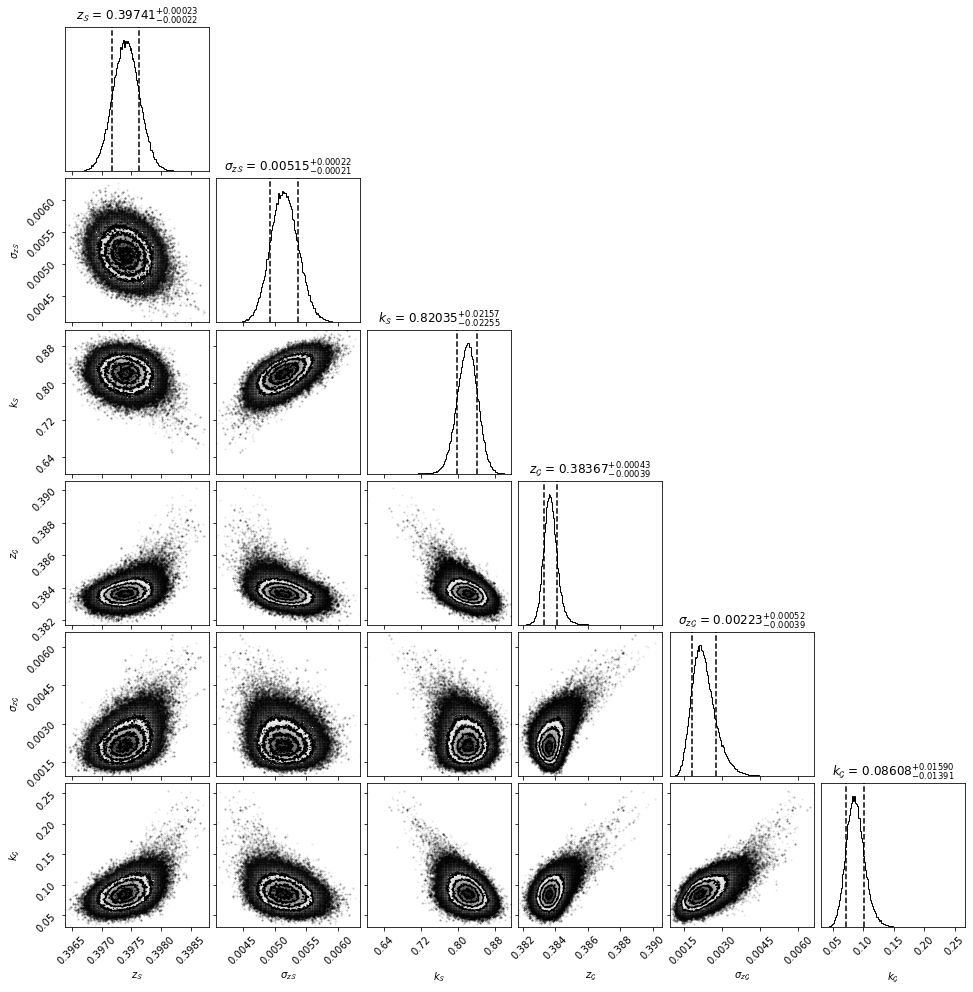

In [18]:
corner.corner(sampler1.flatchain[:],bins=200, quantiles=[0.16, 0.84],
              show_titles=True,title_fmt='.5f', labels=['$z_\mathcal{S}$', '$\sigma_{z\mathcal {S}}$', '$ k_{\mathcal{S}}$', '$z_\mathcal{G}$', '$\sigma_{z\mathcal{G}}$', '$ k_{\mathcal{G}}$']);
plt.savefig('CornerUnknown.pdf')

In [35]:
z_cluster = corner.quantile(sampler1.flatchain[:,0], 0.5)
err_z = 0.5*(corner.quantile(sampler1.flatchain[:,0], 0.84)-corner.quantile(sampler1.flatchain[:,0], 0.16))
sigma_z = corner.quantile(sampler1.flatchain[:,1], 0.5)
err_sigma_z = 0.5*(corner.quantile(sampler1.flatchain[:,1], 0.84)-corner.quantile(sampler1.flatchain[:,1], 0.16))

print(corner.quantile(sampler1.flatchain[:,0], 0.025),corner.quantile(sampler1.flatchain[:,0], 0.975))
print(corner.quantile(sampler1.flatchain[:,1], 0.025),corner.quantile(sampler1.flatchain[:,1], 0.975))
print(corner.quantile(sampler1.flatchain[:,3], 0.025),corner.quantile(sampler1.flatchain[:,3], 0.975))
print(corner.quantile(sampler1.flatchain[:,4], 0.025),corner.quantile(sampler1.flatchain[:,4], 0.975))

sigma_v = c*sigma_z/(1+z_cluster)
err_sigma_v = sigma_v*np.sqrt((err_sigma_z/sigma_z)**2+(err_z/(1+z_cluster))**2)



print('Redshift cluster')
print(z_cluster)
print(err_z)
print('Dispersione velocità (km/s)')
print(sigma_v/1000)
print(err_sigma_v/1000)

cluster = selected[(z>z_cluster-2*sigma_z)&(z<z_cluster+2*sigma_z)]
#print(len(cluster))

R = 2*10**6*(150*10**9*3600*180/np.pi)     #2Mpc-->metri
#err_R = R*err_z/z_cluster
err_R = 0.
M_tot = np.pi*(sigma_v**2)*R/(G*m_sun)     #massa 2D con SIS
err_M_tot = M_tot*np.sqrt(4*(err_sigma_v/sigma_v)**2+(err_R/R)**2)
print('Massa totale (M_sun) modello SIS')
print(M_tot)
print(err_M_tot)

M_vir1 = 5*(sigma_v**2)*R/(G*m_sun)     #massa viriale
err_M_vir1 = M_vir1*np.sqrt(4*(err_sigma_v/sigma_v)**2+(err_R/R)**2)
print('Massa totale (M_sun) viriale')
print(M_vir1)
print(err_M_vir1)

vels_sum = c*sampler1.flatchain[:,1]/(1+sampler1.flatchain[:,0])
#plt.hist(vels, bins=100);
velsum = corner.quantile(vels_sum, 0.5)
err_velsum_sx = (corner.quantile(vels_sum, 0.16)-corner.quantile(vels_sum, 0.5))
err_velsum_dx = (corner.quantile(vels_sum, 0.84)-corner.quantile(vels_sum, 0.5))
print(velsum/1000,err_velsum_sx/1000,err_velsum_dx/1000)

Ms_virsum = 5*(vels_sum**2)*R/(G*m_sun)     #massa viriale
#plt.hist(Ms_virsec, bins=100);
M_virsum = corner.quantile(Ms_virsum, 0.5)
err_M_virsum_sx = (corner.quantile(Ms_virsum, 0.16)-corner.quantile(Ms_virsum, 0.5))
err_M_virsum_dx = (corner.quantile(Ms_virsum, 0.84)-corner.quantile(Ms_virsum, 0.5))
print('Massa totale (M_sun) viriale', M_virsum, err_M_virsum_sx, err_M_virsum_dx)

[0.39696603] [0.39785681]
[0.00473873] [0.0055949]
[0.38289345] [0.38469775]
[0.00151932] [0.00341698]
Redshift cluster
[0.39740639]
[0.00022418]
Dispersione velocità (km/s)
[1104.9297531]
[46.49342426]
Massa totale (M_sun) modello SIS
[1.7886882e+15]
[1.50529459e+14]
Massa totale (M_sun) viriale
[2.84678568e+15]
[2.39575076e+14]
[1104.93359336] [-45.29429916] [47.76450429]
Massa totale (M_sun) viriale [2.84680547e+15] [-2.28613143e+14] [2.51445463e+14]


In [ ]:
zc = np.array(cluster['Z'])
plt.hist(zc, bins=30);

64.038892
-24.072925


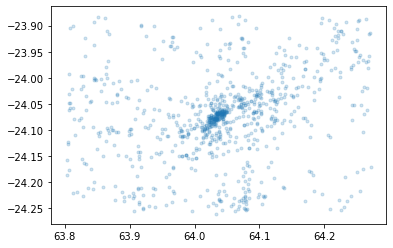

In [46]:
print(np.median(cluster['RA']))
print(np.median(cluster['DEC']))
plt.plot(cluster['RA'], cluster['DEC'], '.', alpha=0.2);

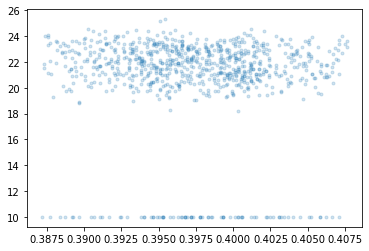

In [41]:
plt.plot(cluster['Z'], cluster['Mag'],'.', alpha=0.2);

In [42]:
D = 1107.5 #Mpc calcolata da http://www.astro.ucla.edu/~wright/CosmoCalc.html
dim = D*0.05*np.pi/180
print(dim)

0.9664760732918599


In [73]:
z_sec = corner.quantile(sampler.flatchain[:,3], 0.5)
err_zsec = 0.5*(corner.quantile(sampler.flatchain[:,3], 0.84)-corner.quantile(sampler.flatchain[:,3], 0.16))
sigma_zsec = corner.quantile(sampler.flatchain[:,4], 0.5)
err_sigma_zsec = 0.5*(corner.quantile(sampler.flatchain[:,4], 0.84)-corner.quantile(sampler.flatchain[:,4], 0.16))
print('Redshift Cluster secondario', z_sec, err_zsec)

sigma_vsec = c*sigma_zsec/(1+z_sec)
err_sigma_vsec = sigma_vsec*np.sqrt((err_sigma_zsec/sigma_zsec)**2+(err_zsec/(1+z_sec))**2)
print('Metodo Propagazione: ', sigma_vsec/1000, err_sigma_vsec/1000)


vels_sec = c*sampler.flatchain[:,4]/(1+sampler.flatchain[:,3])
#plt.hist(vels, bins=100);
velsec = corner.quantile(vels, 0.5)
err_velsec_sx = (corner.quantile(vels_sec, 0.16)-corner.quantile(vels_sec, 0.5))
err_velsec_dx = (corner.quantile(vels_sec, 0.84)-corner.quantile(vels_sec, 0.5))
print('Metodo Distribuzione:', velsec/1000, err_velsec_sx/1000, err_velsec_dx/1000)

Ms_virsec = 5*(vels**2)*R/(G*m_sun)     #massa viriale
#plt.hist(Ms_virsec, bins=100);
M_virsec = corner.quantile(Ms_virsec, 0.5)
err_M_virsec_sx = (corner.quantile(Ms_virsec, 0.16)-corner.quantile(Ms_virsec, 0.5))
err_M_virsec_dx = (corner.quantile(Ms_virsec, 0.84)-corner.quantile(Ms_virsec, 0.5))
print('Massa totale (M_sun) viriale', M_virsec, err_M_virsec_sx, err_M_virsec_dx)

Redshift Cluster secondario [0.38367073] [0.00040391]
Metodo Propagazione:  [484.26867771] [98.06970712]
Metodo Distribuzione: [484.30567649] [-86.00068178] [110.06002324]
Massa totale (M_sun) viriale [5.46920945e+14] [-1.76993169e+14] [2.76824288e+14]


In [25]:
def log_likelihood(p, z):
    z0, sigmaz0, z1, sigmaz1 = p    #parametri della distribuzione
    
    log_p = np.log(0.5*np.exp(-(z0-z)**2 / (2*(sigmaz0**2)))/(2*np.pi*(sigmaz0**2))**0.5+0.5*np.exp(-(z1-z)**2 / (2*(sigmaz1**2)))/(2*np.pi*(sigmaz1**2))**0.5)         #mistura 3 gaussiane + uniforme
    return np.sum(log_p)
    
def log_prior(p):
    z0, sigmaz0, z1, sigmaz1  = p
    if (z0<0.3875 or z0>0.4075) or (z1<0.3875 or z1>0.4075) or (z0<z1) or (sigmaz0<0) or (sigmaz1<0):   #limiti dei parametri
        return -np.inf
    else:
        return 0     #distribuzione a priori uniforme non normalizzata
    
def log_posterior(p, z, a):
    lp = log_prior(p)
    if np.isfinite(lp):
        return lp + log_likelihood(p, z)
    else:
        return lp

In [26]:
ndim = 4
nwalkers = 20

z0 = np.random.normal(0.40,0.001,size=nwalkers)          #Cluster principale
sigmaz0 = np.random.normal(0.01,0.001,size=nwalkers)
z1 = np.random.normal(0.39,0.001,size=nwalkers)          #Cluster secondario
sigmaz1 = np.random.normal(0.01,0.001,size=nwalkers) 

start = np.zeros((nwalkers,ndim))
for i in range(nwalkers):
    start[i] = (z0[i],sigmaz0[i],z1[i],sigmaz1[i])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(zc, a))  
sampler.run_mcmc(start, 20000, progress=True);
sampler.reset()
sampler.run_mcmc(initial_state=None,nsteps=30000, progress=True);

100%|██████████| 30000/30000 [00:45<00:00, 659.02it/s]


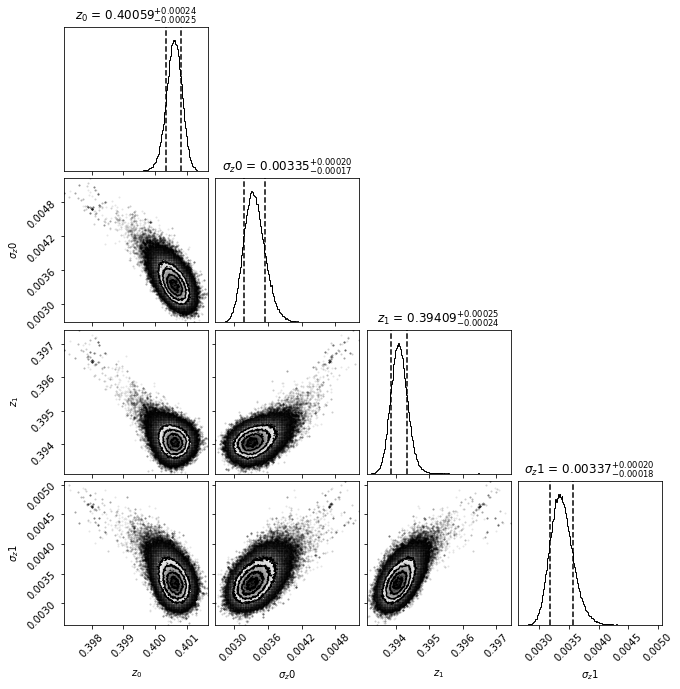

In [27]:
corner.corner(sampler.flatchain[:],bins=200, quantiles=[0.16, 0.84],
              show_titles=True,title_fmt='.5f', labels=['$z_0$', '$\sigma_z0$', '$z_1$', '$\sigma_z1$']);

[0.40005561] [0.40104437]
[0.00302481] [0.00378935]
[0.39363148] [0.39462979]
[0.00303639] [0.00380877]
Redshift 0 [0.40059142] [0.00024265]
Metodo Distribuzione: [718.01536532] [-37.35526511] [43.1774496]
Redshift 1 [0.39408777] [0.00024543]
Metodo Distribuzione: [724.19177164] [-38.02935846] [43.69017568]
Massa totale (M_sun) viriale [2.42575845e+15] [-2.07971262e+14] [2.61639059e+14]


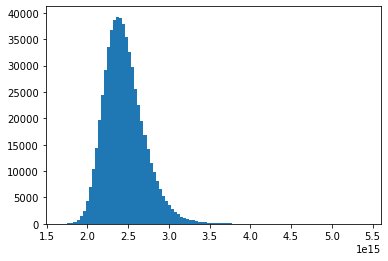

In [38]:
print(corner.quantile(sampler.flatchain[:,0], 0.025),corner.quantile(sampler.flatchain[:,0], 0.975))
print(corner.quantile(sampler.flatchain[:,1], 0.025),corner.quantile(sampler.flatchain[:,1], 0.975))
print(corner.quantile(sampler.flatchain[:,2], 0.025),corner.quantile(sampler.flatchain[:,2], 0.975))
print(corner.quantile(sampler.flatchain[:,3], 0.025),corner.quantile(sampler.flatchain[:,3], 0.975))


z_0 = corner.quantile(sampler.flatchain[:,0], 0.5)
err_z_0 = 0.5*(corner.quantile(sampler.flatchain[:,0], 0.84)-corner.quantile(sampler.flatchain[:,0], 0.16))
sigma_z_0 = corner.quantile(sampler.flatchain[:,1], 0.5)
err_sigma_z_0 = 0.5*(corner.quantile(sampler.flatchain[:,1], 0.84)-corner.quantile(sampler.flatchain[:,1], 0.16))
print('Redshift 0', z_0, err_z_0)


vels_0 = c*sampler.flatchain[:,1]/(1+sampler.flatchain[:,0])
#plt.hist(vels, bins=100);
vel0 = corner.quantile(vels_0, 0.5)
err_vel0_sx = (corner.quantile(vels_0, 0.16)-corner.quantile(vels_0, 0.5))
err_vel0_dx = (corner.quantile(vels_0, 0.84)-corner.quantile(vels_0, 0.5))
print('Metodo Distribuzione:', vel0/1000, err_vel0_sx/1000, err_vel0_dx/1000)

z_1 = corner.quantile(sampler.flatchain[:,2], 0.5)
err_z_1 = 0.5*(corner.quantile(sampler.flatchain[:,2], 0.84)-corner.quantile(sampler.flatchain[:,2], 0.16))
sigma_z_1 = corner.quantile(sampler.flatchain[:,3], 0.5)
err_sigma_z_1 = 0.5*(corner.quantile(sampler.flatchain[:,3], 0.84)-corner.quantile(sampler.flatchain[:,3], 0.16))
print('Redshift 1', z_1, err_z_1)


vels_1 = c*sampler.flatchain[:,3]/(1+sampler.flatchain[:,2])
#plt.hist(vels, bins=100);
vel1 = corner.quantile(vels_1, 0.5)
err_vel1_sx = (corner.quantile(vels_1, 0.16)-corner.quantile(vels_1, 0.5))
err_vel1_dx = (corner.quantile(vels_1, 0.84)-corner.quantile(vels_1, 0.5))
print('Metodo Distribuzione:', vel1/1000, err_vel1_sx/1000, err_vel1_dx/1000)

Ms_vir = 5*((vels_0**2)+(vels_1**2))*R/(G*m_sun)     #massa viriale
plt.hist(Ms_vir, bins=100);
M_vir = corner.quantile(Ms_vir, 0.5)
err_M_vir_sx = (corner.quantile(Ms_vir, 0.16)-corner.quantile(Ms_vir, 0.5))
err_M_vir_dx = (corner.quantile(Ms_vir, 0.84)-corner.quantile(Ms_vir, 0.5))
print('Massa totale (M_sun) viriale', M_vir, err_M_vir_sx, err_M_vir_dx)

QUERY:

select p.ra, p.dec, p.dered_u, p.dered_r, s.z, g.lgm_tot_p50, g.lgm_tot_p16, g.lgm_tot_p84
from PhotoObj p, SpecObj s, galSpecExtra g, dbo.fGetNearbyObjEq(239.5833,27.2334,20) f
where s.bestObjid = p.ObjID AND g.specObjID=s.specObjID AND f.ObjID = p.ObjID AND class = 'galaxy'  AND s.zWarning = 0

In [183]:
def log_likelihood(p, z):
    z0, sigmaz0, sigmaz1 = p    #parametri della distribuzione
    
    log_p = np.log((1-0.08606-0.82117)/0.045+0.5*0.82117*np.exp(-(z0-z)**2 / (2*(sigmaz0**2)))/(2*np.pi*(sigmaz0**2))**0.5+0.5*0.82117*np.exp(-((2*0.39741-z0)-z)**2 / (2*(sigmaz1**2)))/(2*np.pi*(sigmaz1**2))**0.5+0.08606*np.exp(-(0.38366-z)**2 / (2*(0.00224**2)))/(2*np.pi*(0.00224**2))**0.5)         #mistura 3 gaussiane + uniforme
    return np.sum(log_p)
    
def log_prior(p):
    z0, sigmaz0, sigmaz1  = p
    if (z0<0.3875 or z0>0.3945) or (sigmaz0<0) or (sigmaz1<0) :   #limiti dei parametri
        return -np.inf
    else:
        return 0     #distribuzione a priori uniforme non normalizzata
    
def log_posterior(p, z, a):
    lp = log_prior(p)
    if np.isfinite(lp):
        return lp + log_likelihood(p, z)
    else:
        return lp

In [184]:
ndim = 3
nwalkers = 20

z0 = np.random.normal(0.39,0.001,size=nwalkers)          #Cluster principale
sigmaz0 = np.random.normal(0.01,0.001,size=nwalkers)
#z1 = np.random.normal(0.39,0.001,size=nwalkers)          #Cluster secondario
sigmaz1 = np.random.normal(0.01,0.001,size=nwalkers) 

start = np.zeros((nwalkers,ndim))
for i in range(nwalkers):
    start[i] = (z0[i],sigmaz0[i],sigmaz1[i])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(z_sel, a))  
sampler.run_mcmc(start, 2000, progress=True);
sampler.reset()
sampler.run_mcmc(initial_state=None,nsteps=3000, progress=True);

  0%|          | 0/2000 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:05<00:00, 591.14it/s]


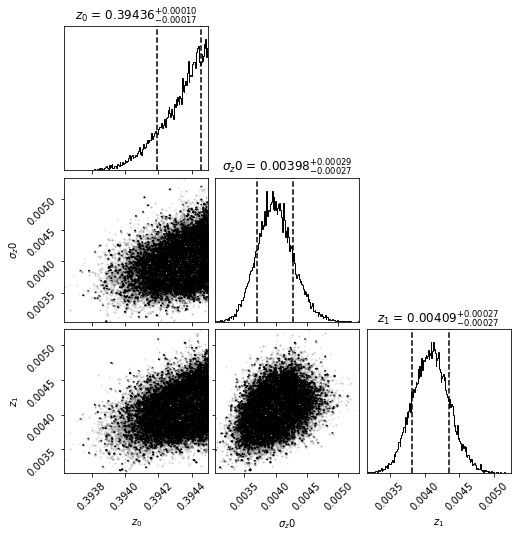

In [185]:
corner.corner(sampler.flatchain[:],bins=200, quantiles=[0.16, 0.84],
              show_titles=True,title_fmt='.5f', labels=['$z_0$', '$\sigma_z0$', '$z_1$', '$\sigma_z1$', 'k', 'z2', 'sigmaz2', 'k2']);



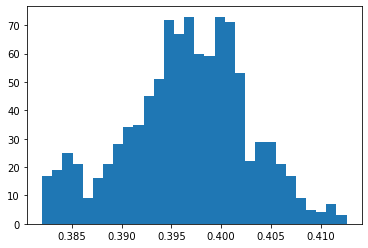

In [159]:
plt.hist(zc, bins=30);

In [8]:
plt.title?

Signature: plt.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)
Docstring:
Set a title for the axes.

Set one of the three available axes titles. The available titles
are positioned above the axes in the center, flush with the left
edge, and flush with the right edge.

Parameters
----------
label : str
    Text to use for the title

fontdict : dict
    A dictionary controlling the appearance of the title text,
    the default *fontdict* is::

       {'fontsize': rcParams['axes.titlesize'],
        'fontweight': rcParams['axes.titleweight'],
        'color': rcParams['axes.titlecolor'],
        'verticalalignment': 'baseline',
        'horizontalalignment': loc}

loc : {'center', 'left', 'right'}, default: :rc:`axes.titlelocation`
    Which title to set.

y : float, default: :rc:`axes.titley`
    Vertical axes loation for the title (1.0 is the top).  If
    None (the default), y is determined automatically to avoid
    decorators on the axes.

pad : float, default: :